import packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

#is_cuda = torch.cuda.is_available()
#device = torch.device('cuda' if is_cuda else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

data manipulation

In [5]:
import torchvision.transforms as transforms
compose = transforms.Compose([
    transforms.CenterCrop((200,330)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_dir = '/content/drive/MyDrive/dataset_doeun_0825/spec/'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=compose)

In [6]:
len(dataset)

1090

In [7]:
from torch.utils.data import random_split
seed_everything(42)
train_data, test_data = random_split(dataset,[890,200])

In [8]:
from sklearn.model_selection import KFold
from torch.utils import data

seed_everything(12)
folds = KFold(n_splits=5,shuffle=True)
train = []
valid = []

for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
    dataset_train = data.Subset(train_data, train_idx)
    dataset_valid = data.Subset(train_data, valid_idx)
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle =True)
    train.append(trainloader)
    validloader = torch.utils.data.DataLoader(dataset_valid, batch_size=10, shuffle=True)
    valid.append(validloader)

In [ ]:
for i_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data)):
  print(i_fold)
  print('train',valid_idx)

0
train [  11   14   16   28   33   38   43   52   66   74   75   81   84   88
   89   91   97   98  101  129  130  131  132  134  141  147  151  158
  163  167  172  175  184  188  190  200  204  206  207  210  213  220
  221  226  227  228  231  235  241  248  250  252  258  261  270  276
  278  287  288  289  295  296  301  303  306  335  338  341  342  344
  349  360  366  371  372  382  385  386  400  405  408  410  413  451
  454  467  469  470  473  478  482  485  489  491  501  505  507  514
  515  519  525  532  535  536  546  557  571  573  577  586  595  596
  601  602  603  606  611  613  622  623  628  632  633  637  642  643
  647  651  652  658  672  674  680  689  691  694  702  704  719  720
  726  727  730  733  734  739  747  751  756  761  763  768  775  786
  787  789  796  803  805  808  810  817  819  834  837  847  848  850
  862  868  869  873  874  886  895  896  898  899  903  908  910  911
  921  925  931  935  939  943  953  955  958  959  963  967  968  97

torch.Size([10, 3, 224, 224])
torch.Size([3, 224, 224])


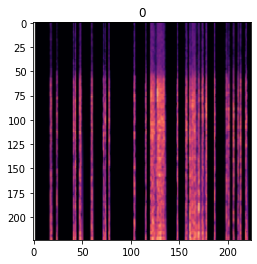

In [ ]:
import matplotlib.pyplot as plt
ToPILImage = transforms.Compose([
    transforms.ToPILImage()
])

for data, target in trainloader:
    index = 5
    print(data.shape)
    img = data[index]
    print(img.shape)
    pic = ToPILImage(img)
    plt.title(int(target[index]))
    plt.imshow(pic)
    plt.show()
    break

In [ ]:
print(len(train[0]),len(valid[0]))

88 22


### Resnet

In [9]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [10]:
from torchvision.models import resnet50
model = resnet50(pretrained = False)

model.l1 = nn.Linear(2048, 2)
nn.init.kaiming_normal_(model.l1.weight)

model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Dropout(0.5),
                         model.l1)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
n = 0
for data, target in train[0]:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([10, 3, 224, 224])
tensor([[-2.3543, -2.6057],
        [ 1.1492,  2.9209],
        [-2.1242, -3.2539],
        [ 2.5226,  0.5125],
        [-0.6544,  0.6675],
        [-0.0204, -2.1368],
        [-0.8438,  3.7489],
        [ 0.1360,  0.4863],
        [ 1.0426,  0.5959],
        [ 0.2636,  0.1397]], device='cuda:0')
tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0]) tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1])


In [12]:
num=[]
for _, test_target in valid[0]:
  num += test_target
print(sum(num))

tensor(97)


In [13]:
list_training_loss = []
list_test_loss = []

In [14]:
def training_model(n_epochs, last_epoch, trainloader, testloader, seed, device, lr=0.001):
  seed_everything(seed)
  optimizer = torch.optim.Adam(model.parameters(), lr)
  criterion = nn.CrossEntropyLoss().to(device)

  for epoch in range(n_epochs):
    n_train, train_loss = 0,0
    model.train()
    for train_data, train_target in trainloader:
      train_data, train_target = train_data.to(device), train_target.to(device)
      y = model(train_data)
      del train_data
      loss = criterion(y, train_target).sum()
      train_loss += loss.data.cpu().numpy()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      n_train += 1
      del train_target
    
    if (epoch % 4 == 0) | (epoch == n_epochs-1):
      model.eval()
      n_test, test_loss = 0, 0
      correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
      for test_data, test_target in testloader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = correct * 100 / total
      recall = TP * 100 / (total - num_non)
      precision = TP * 100 / (total - pred_non)
      f1score = 2 *(precision*recall) / (precision + recall)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + last_epoch + 1, train_loss / n_train, test_loss / n_test, accuracy, precision, recall, f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

In [16]:
training_model(50, 0, train[0], valid[0], 42, device, lr=0.001)

epoch 1th training loss: 1.060467479336593 test loss: 0.6837768329100476, accuracy: 75.84269714355469, precision: 74.35897064208984, recall: 71.60493469238281, f1 score: 72.95597839355469
epoch 5th training loss: 0.576418839653747 test loss: 0.6979447942641046, accuracy: 73.59550476074219, precision: 84.0, recall: 51.85185241699219, f1 score: 64.12213897705078
epoch 9th training loss: 0.5643634225966202 test loss: 0.44568911877771217, accuracy: 83.7078628540039, precision: 77.08333587646484, recall: 91.35802459716797, f1 score: 83.6158218383789
epoch 13th training loss: 0.5571228387351665 test loss: 0.694925773746541, accuracy: 82.02247619628906, precision: 73.78640747070312, recall: 93.82716369628906, f1 score: 82.60869598388672
epoch 17th training loss: 0.4777925117329384 test loss: 0.978981984158357, accuracy: 77.52809143066406, precision: 70.29702758789062, recall: 87.6543197631836, f1 score: 78.02197265625
epoch 21th training loss: 0.634942691333385 test loss: 1.1515165761941009, 

1-100


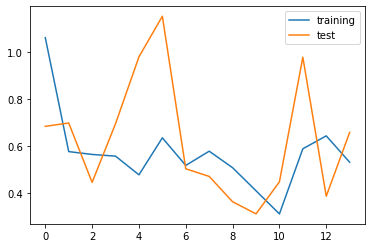

In [17]:
import matplotlib.pyplot as plt

print('1-50')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [18]:
training_model(50, 50, train[1], valid[1], 14, device, lr=0.001)

epoch 51th training loss: 0.6790248753709925 test loss: 1.5628104938401117, accuracy: 75.28089904785156, precision: 73.07691955566406, recall: 82.60869598388672, f1 score: 77.551025390625
epoch 55th training loss: 0.555001895951591 test loss: 5.100855985656381, accuracy: 77.52809143066406, precision: 84.21052551269531, recall: 69.56521606445312, f1 score: 76.19047546386719
epoch 59th training loss: 0.5575868495636516 test loss: 0.4649542147914569, accuracy: 78.08988952636719, precision: 92.06349182128906, recall: 63.043479919433594, f1 score: 74.83871459960938
epoch 63th training loss: 0.6389858581953578 test loss: 0.41803456097841263, accuracy: 84.83145904541016, precision: 91.13924407958984, recall: 78.26087188720703, f1 score: 84.21053314208984
epoch 67th training loss: 0.5404916179055969 test loss: 0.7099028817481465, accuracy: 78.08988952636719, precision: 71.19999694824219, recall: 96.73912811279297, f1 score: 82.02764892578125
epoch 71th training loss: 0.6149273504916992 test lo

1-100


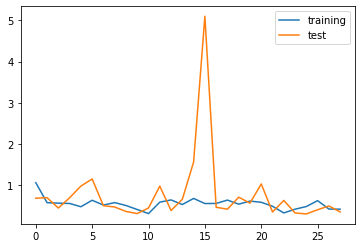

In [19]:
import matplotlib.pyplot as plt

print('1-100')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [20]:
training_model(50, 100, train[2], valid[2], 12, device, lr=0.001)

epoch 101th training loss: 0.5363549261075806 test loss: 0.4990852464818292, accuracy: 78.08988952636719, precision: 98.27586364746094, recall: 60.0, f1 score: 74.50980377197266
epoch 105th training loss: 0.38202668162476683 test loss: 0.2666003724767102, accuracy: 87.64044952392578, precision: 86.86869049072266, recall: 90.52631378173828, f1 score: 88.65979766845703
epoch 109th training loss: 0.4802462982220782 test loss: 0.275193785627683, accuracy: 85.39325714111328, precision: 85.56700897216797, recall: 87.36842346191406, f1 score: 86.45833587646484
epoch 113th training loss: 0.5923102245562606 test loss: 0.48004610484672916, accuracy: 81.46067810058594, precision: 75.40983581542969, recall: 96.84210205078125, f1 score: 84.7926254272461
epoch 117th training loss: 0.4980240126864778 test loss: 0.4894932990686761, accuracy: 80.33708190917969, precision: 73.07691955566406, recall: 100.0, f1 score: 84.44444274902344
epoch 121th training loss: 0.65643632489567 test loss: 0.6267266265220

1-150


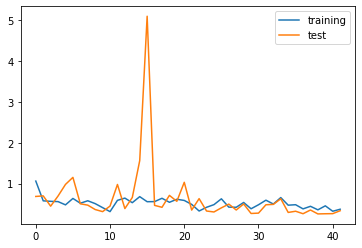

In [21]:
import matplotlib.pyplot as plt

print('1-150')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [22]:
training_model(50, 150, train[3], valid[3], 10, device, lr=0.001)

epoch 151th training loss: 0.3579319943415208 test loss: 0.22353128504215014, accuracy: 88.76404571533203, precision: 88.0434799194336, recall: 90.0, f1 score: 89.010986328125
epoch 155th training loss: 0.4855293985003502 test loss: 0.2672963577012221, accuracy: 87.07865142822266, precision: 91.35802459716797, recall: 82.22222137451172, f1 score: 86.5497055053711
epoch 159th training loss: 0.32558838055572575 test loss: 0.23900133508464527, accuracy: 89.88764190673828, precision: 88.2978744506836, recall: 92.22222137451172, f1 score: 90.21739196777344
epoch 163th training loss: 0.2812252685253043 test loss: 0.26035209921085173, accuracy: 86.51685333251953, precision: 86.66666412353516, recall: 86.66666412353516, f1 score: 86.66666412353516
epoch 167th training loss: 0.281883328149383 test loss: 0.3401520798603694, accuracy: 87.07865142822266, precision: 95.89041137695312, recall: 77.77777862548828, f1 score: 85.88957214355469
epoch 171th training loss: 0.7021728667120138 test loss: 0.6

1-200


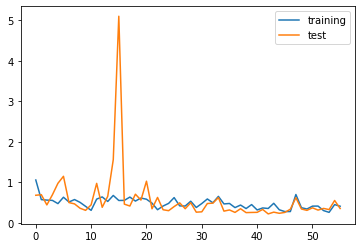

In [23]:
import matplotlib.pyplot as plt

print('1-200')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [24]:
training_model(50, 200, train[4], valid[4], 10, device, lr=0.001)

epoch 201th training loss: 0.4250635017847849 test loss: 0.253894555899832, accuracy: 91.57303619384766, precision: 93.54838562011719, recall: 90.625, f1 score: 92.06349182128906
epoch 205th training loss: 0.2515823081727528 test loss: 0.32388873149951297, accuracy: 85.9550552368164, precision: 91.76470947265625, recall: 81.25, f1 score: 86.18785095214844
epoch 209th training loss: 0.35475936967931276 test loss: 0.3559115016832948, accuracy: 85.39325714111328, precision: 81.25, recall: 94.79166412353516, f1 score: 87.5
epoch 213th training loss: 0.2862159307373481 test loss: 0.23870367825859123, accuracy: 89.32584381103516, precision: 93.25843048095703, recall: 86.45833587646484, f1 score: 89.729736328125
epoch 217th training loss: 0.3389760670688702 test loss: 0.3001454175553388, accuracy: 88.2022476196289, precision: 93.10344696044922, recall: 84.375, f1 score: 88.52458953857422
epoch 221th training loss: 0.39556666039344335 test loss: 0.23280045555697548, accuracy: 89.88764190673828

1-250


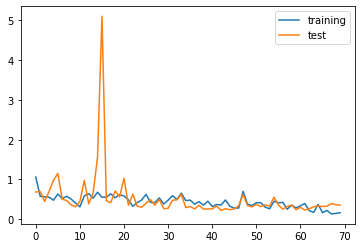

In [38]:
import matplotlib.pyplot as plt

print('1-250')
plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

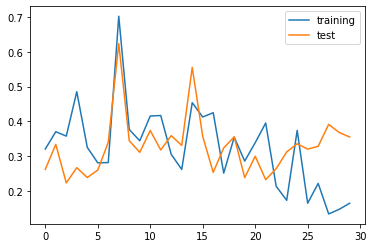

In [39]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss[40:], label='training')
plt.plot(list_test_loss[40:], label='test')
plt.legend()
plt.show()

In [28]:
torch.save(model, 'model_cough.pt') 

In [26]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle =True)

In [27]:
model.eval()

correct, total, num_non, pred_non, TP  = 0, 0, 0, 0, 0
for test_data, test_target in testloader:
  test_data = test_data.to(device)
  test_target = test_target.to(device)
  y_pred = model(test_data)
  idx_pred = torch.max(y_pred, 1)[1]
  del test_data
  total += len(test_target)
  num_non += test_target.sum()
  pred_non += idx_pred.sum()
  correct += (idx_pred == test_target).sum()
  TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

accuracy = correct * 100 / total
recall = TP * 100 / (total - num_non)
precision = TP * 100 / (total - pred_non)
f1score = 2 *(precision*recall) / (precision + recall)
print('accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(accuracy, precision, recall, f1score))

accuracy: 81.0, precision: 76.92308044433594, recall: 85.10638427734375, f1 score: 80.8080825805664
